# Task 3: Transfer Learning

In [30]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from sklearn.metrics import confusion_matrix


import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import importlib
import seaborn as sns
import sys

import src.preprocessing as preprocessing
import src.models as models

importlib.reload(preprocessing)
importlib.reload(models)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Set up your Image Generators for the training, validation, and test data.
img_height, img_width = 128, 128
channels = 3
batch_size = 32

path_train = "../data/train"
path_val = "../data/val"
path_test = "../data/test"

train_data_gen = preprocessing.get_image_generator(
    path_train, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=True, 
    preprocess=True)

val_data_gen = preprocessing.get_image_generator(
    path_val, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=False, 
    preprocess=False)
test_data_gen = preprocessing.get_image_generator(
    path_test, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=False, 
    preprocess=False)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [3]:
# Set up the classification
metrics=['accuracy']

# Base Model

In [ ]:
model.add(Conv2D(256, (1, 1), activation='relu'))  # 1x1 conv to reduce feature dimensions

# Add spatial dropout to prevent overfitting
model.add(SpatialDropout2D(0.3))

# Global pooling
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [39]:
# Base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False  # freeze all layers

# Create the model
model = Sequential()
model.add(base_model)


model.add(Conv2D(256, (1, 1), activation='relu'))  # 1x1 conv to reduce feature dimensions
model.add(MaxPooling2D())

# Add spatial dropout to prevent overfitting
model.add(SpatialDropout2D(0.3))

# Global pooling
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000500)
model.compile(optimizer='adadelta', loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 2, 2, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,221,441 (92.40 MB)

 Trainable params: 656,641 (2.50 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

# Train the Model


In [5]:
#The Best Hyperparameters
results_csv = "../results/hyperparameter_tuning_results.csv"
df_results = pd.read_csv(results_csv)

# Select the best configuration based on highest validation accuracy.
best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_dropout = best_config['dropout_rate']
best_filters = int(best_config['first_filters'])
best_lr = best_config['learning_rate']
best_dense_units = int(best_config['dense_units'])

print("Best Hyperparameters:")
print(best_config)


Best Hyperparameters:
dropout_rate           0.100000
first_filters          8.000000
learning_rate          0.000500
dense_units          512.000000
best_val_accuracy      0.877604
best_epoch             5.000000
final_val_loss         0.333219
Name: 6, dtype: float64


In [9]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [40]:
#Train

epochs = 30

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 520ms/step - accuracy: 0.5362 - loss: 1.0707 - val_accuracy: 0.6693 - val_loss: 0.6281
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 507ms/step - accuracy: 0.5464 - loss: 1.0228 - val_accuracy: 0.6693 - val_loss: 0.6123
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 511ms/step - accuracy: 0.5459 - loss: 1.0000 - val_accuracy: 0.6771 - val_loss: 0.6016
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 642ms/step - accuracy: 0.5893 - loss: 0.9097 - val_accuracy: 0.6901 - val_loss: 0.5938
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 567ms/step - accuracy: 0.6007 - loss: 0.9079 - val_accuracy: 0.6875 - val_loss: 0.5849
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 551ms/step - accuracy: 0.6328 - loss: 0.8231 - val_accuracy: 0.7031 - val_loss: 0.5765
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 563ms/step - accuracy: 0.6212 - loss: 0.8342 - val_accuracy: 0.7083 - val_loss: 0.5671
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 558ms/step - accuracy: 0.6422 - loss: 0.7700 - val_accu

### Model evaluation

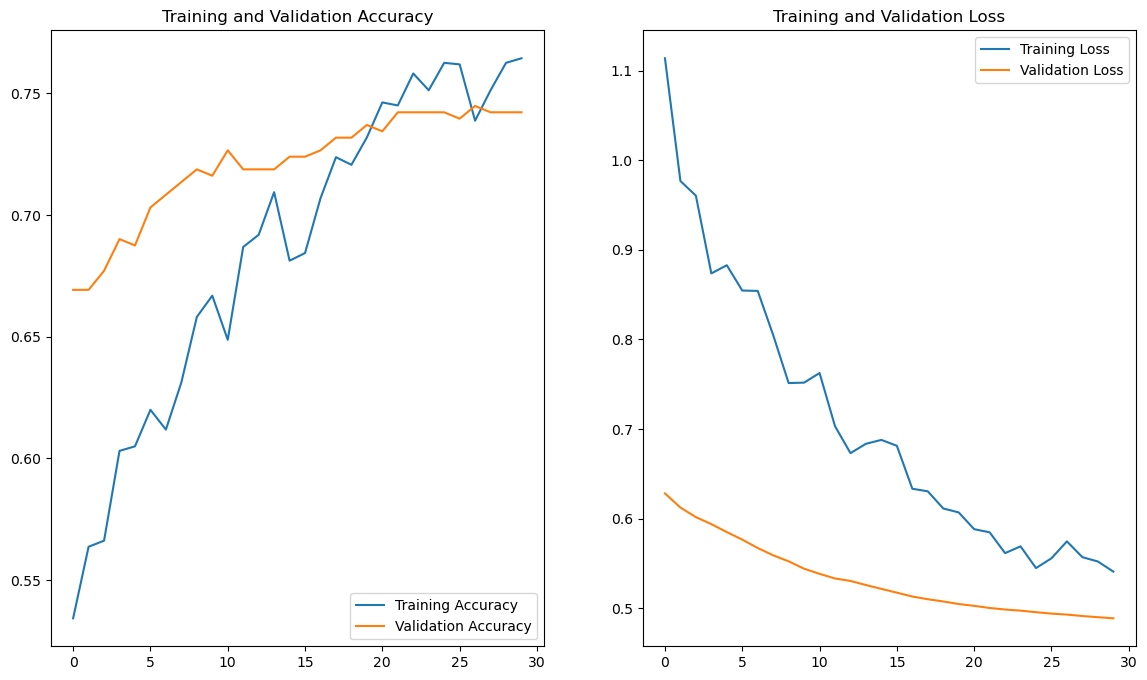

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Hyperparameter tuning

In [23]:
# Hyperparameter options.
batch_size = [32, 64]
learning_rates = [0.001, 0.0005] 
dropout_rates = [0.1, 0.2]

# Define EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

epochs = 5

# Create hyperparameter grid and convert it to a list for progress calculation.
hyperparameter_grid = list(product(batch_size, learning_rates, dropout_rates))
total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (batch_size, learning_rates, dropout_rates) in enumerate(hyperparameter_grid):
    print(f"\nRunning: batch_size={batch_size}, learning_rate={learning_rates}, dropout_rate={dropout_rates}")
    
    # Build the model with the current hyperparameters.
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base_model.trainable = False  # freeze all layers
    model = Sequential()
    model.add(base_model)   
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rates))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rates))
    model.add(Dense(1, activation='sigmoid'))
    
    # Set up the optimizer and compile the model.
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rates)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    

    
    
    
    
    
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'dropout_rate': dropout_rates,
        'learning_rate': learning_rates,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss 
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")



# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results_transfer_learning.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Total iterations: 8

Running: batch_size=32, learning_rate=0.001, dropout_rate=0.1


KeyboardInterrupt: 

# Train pre-trained model

In [ ]:
#Retrain your model using the complete training dataset (including the validation dataset)

# Base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False

# Create the model
model = Sequential()
model.add(base_model)




model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000500)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

model.summary()

In [ ]:
path_train_and_val = "../data/train_and_val"

train_and_val_data_gen = preprocessing.get_image_generator(
    path_train_and_val, 
    img_height, 
    img_width, 
    batch_size, 
    shuffle=True, 
    preprocess=True

In [ ]:
#Train

epochs = 30

history = model.fit(
    train_and_val_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

In [ ]:
# Plot the training curve

# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(epochs_full)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [ ]:
# Save and reload your model

# Define the path where the model will be saved.
model_save_path = "../results/final_transfer_learning.keras"

# Save the retrained model to disk.
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

# Fine-tuning the entire model

In [ ]:
#unfreeze the base model

# Base model
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = True

# Create the model
model = Sequential()
model.add(base_model)




model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000500)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

model.summary()



In [ ]:
#Train the model

epochs = 30

history = model.fit(
    train_and_val_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

In [ ]:
#Save the model in a different file and reload it

# Define the path where the model will be saved.
model_save_path = "../results/final2_transfer_learning.keras"

# Save the retrained model to disk.
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

In [ ]:
#Test the modal on the testdata

test_loss, test_accuracy = model.evaluate(
    test_data_gen, 
    steps=steps_test,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
#confussion matrix

# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions > 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

# Create a confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()   


In [ ]:
#samples from the testdata with and without pre-processing (with their evaluations)

#without pre-processing

#with pre-processing